# US baby names dataset

## Install and import modules

In [1]:
# Uncomment to install software
# ! pip install --quiet coniferest
! pip install --quiet pandas
! pip install --quiet requests

In [2]:
import zipfile
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from coniferest.pineforest import PineForest
from coniferest.isoforest import IsolationForest
from coniferest.pineforest import PineForest
from coniferest.session import Session
from coniferest.session.callback import TerminateAfter, prompt_decision_callback, Label

## Data preparation

Download data and put into a single data frame

In [3]:
%%time

URL = 'https://www.ssa.gov/OACT/babynames/state/namesbystate.zip'

response = requests.get(URL)
if not response.ok:
    raise RuntimeError('Cannot download the file')

dfs = []
with zipfile.ZipFile(BytesIO(response.content)) as zip_ref:
    for filename in zip_ref.namelist():
        if not filename.lower().endswith('.txt'):
            continue
        with zip_ref.open(filename) as f:
            df = pd.read_csv(f, header=None, names=['State', 'Gender', 'Year', 'Name', 'Count'])
        dfs.append(df)
raw = pd.concat(dfs, axis=0, ignore_index=True)

raw

CPU times: user 1.46 s, sys: 198 ms, total: 1.66 s
Wall time: 3.76 s


,State,Gender,Year,Name,Count
0,AK,F,1910,Mary,14
1,AK,F,1910,Annie,12
2,AK,F,1910,Anna,10
3,AK,F,1910,Margaret,8
4,AK,F,1910,Helen,7
...,...,...,...,...,...
6408036,WY,M,2022,Lane,5
6408037,WY,M,2022,Michael,5
6408038,WY,M,2022,Nicholas,5
6408039,WY,M,2022,River,5


Let's load the data and transform it into a feature matrix where each column is the number (normalized) of americans that got this name in a given year (from 1910 to 2014). We apply few quality filter. We should at least have data in 10 years, otherwise we consider it too much missing data and drop the name. We also require the name to appear at least 10000 times over the full time range, this will prevent noisy data from names that are barely used. 

In [4]:
%%time

WITH_FFT = True

raw = pd.read_csv('StateNames.csv')
all_years = np.unique(raw['Year'])
all_names = np.unique(raw['Name'])

# Accumulate names over states and genders
counts = raw.groupby(['Name', 'Year']).apply(lambda df: df['Count'].sum(), include_groups=False)

# Tranform to dataframe where names are labels, years are columns and counts are values (features)
years = [f'year_{i}' for i in all_years]
year_columns = pd.DataFrame(data=0.0, index=all_names, columns=years)
for name, year in counts.index:
    year_columns.loc[name, f'year_{year}'] = counts.loc[name, year]

# Account for total population changes
trend = year_columns.sum(axis=0)
detrended = year_columns / trend

# Normalise and filter
norm = detrended.apply(lambda column: column / detrended.max(axis=1))
filtered = norm[year_columns.sum(axis=1) >= 10_000]

if WITH_FFT:
    # Fourier-transform, normalize by zero frequency and get power-spectrum for few lowest frequencies
    power_spectrum = np.square(np.abs(np.fft.fft(filtered)))
    power_spectrum_norm = power_spectrum / power_spectrum[:, 0, None]
    power_spectrum_low_freq = power_spectrum_norm[:, 1:21]
    frequencies = [f'freq_{i}' for i in range(power_spectrum_low_freq.shape[1])]
    power = pd.DataFrame(data=power_spectrum_low_freq, index=filtered.index, columns=frequencies)
    
    # Concatenate time-series data and power spectrum
    final = pd.merge(filtered, power, left_index=True, right_index=True)
else:
    # Use time-series data
    final = filtered

final

CPU times: user 26.6 s, sys: 787 ms, total: 27.4 s
Wall time: 27.2 s


,year_1910,year_1911,year_1912,year_1913,year_1914,year_1915,year_1916,year_1917,year_1918,year_1919,...,freq_10,freq_11,freq_12,freq_13,freq_14,freq_15,freq_16,freq_17,freq_18,freq_19
Aaliyah,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.041389,0.040285,0.026800,0.009486,0.000807,0.003196,0.010379,0.014623,0.013153,0.009083
Aaron,0.045732,0.053763,0.062046,0.077350,0.075002,0.065579,0.066919,0.066029,0.065506,0.066271,...,0.000917,0.000105,0.000460,0.000239,0.000022,0.000215,0.000626,0.000378,0.000047,0.000182
Abbey,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.003518,0.000225,0.000774,0.001246,0.000350,0.000023,0.000136,0.000208,0.000214,0.000289
Abbie,0.359799,0.269697,0.306336,0.464435,0.215457,0.302285,0.349093,0.307475,0.197717,0.346186,...,0.001090,0.000042,0.001033,0.001286,0.000146,0.000136,0.000110,0.000129,0.000283,0.000443
Abby,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.001872,0.000465,0.002183,0.001577,0.000327,0.000047,0.000254,0.000429,0.000157,0.000137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zane,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.007848,0.006733,0.005006,0.002438,0.002929,0.002950,0.002658,0.002947,0.003716,0.002794
Zelma,0.932439,1.000000,0.729409,0.723820,0.652391,0.669589,0.600087,0.576376,0.536166,0.576344,...,0.010900,0.009167,0.007125,0.005689,0.005621,0.005968,0.005882,0.006382,0.005040,0.002785
Zion,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.014608,0.002243,0.001477,0.009674,0.018779,0.021973,0.017112,0.008395,0.002003,0.000994
Zoe,0.009252,0.000000,0.003228,0.000000,0.001847,0.002544,0.004278,0.004376,0.002135,0.001222,...,0.022776,0.017654,0.011233,0.007332,0.005073,0.003497,0.002774,0.002610,0.002163,0.001578


Plotting function

In [5]:
def basic_plot(idx):
    cols = [col.startswith('year') for col in final.columns]
    all_years = [int(col.removeprefix('year_')) for col in final.columns[cols]]
    
    if isinstance(idx, str):
        counts = final.loc[idx][cols]
        title = idx
    else:
        counts = final.iloc[idx][cols]
        title = final.iloc[idx].name
    
    plt.plot(all_years, counts.values)
    # plt.ylim(-0.1, 1.1)
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.show()

We can now easily look at the evolution of a given name over the years

2045


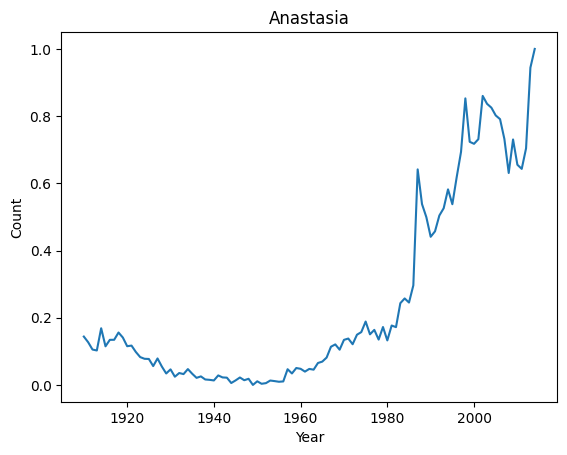

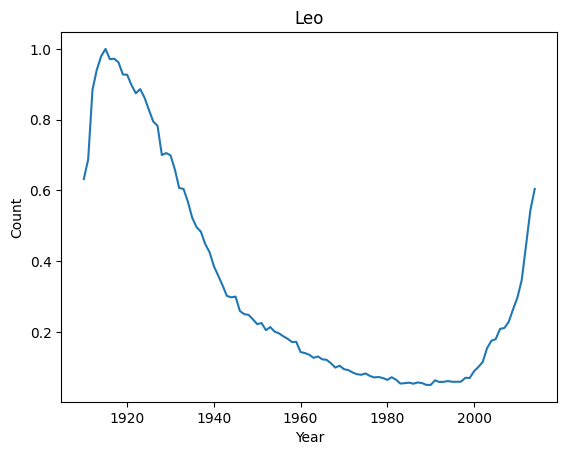

In [6]:
print(len(final))
basic_plot('Anastasia')
basic_plot('Leo')

## Classical anomaly detection

In [7]:
model = IsolationForest(random_seed=1, n_trees=1000)
model.fit(np.array(final))
scores = model.score_samples(np.array(final))
ordered_scores, ordered_index = zip(*sorted(zip(scores, final.index)))

print(f"Top 10 weirdest names : {ordered_index[:10]}")
print(f"Top 10 most normal names : {ordered_index[-10:]}")

Top 10 weirdest names : ('Manuel', 'Alfonso', 'Margarita', 'Marshall', 'Alonzo', 'Byron', 'Benito', 'Vincent', 'Peter', 'Rudy')
Top 10 most normal names : ('Jazmin', 'Arianna', 'Drake', 'Lukas', 'Ashlynn', 'Kiley', 'Ariana', 'Mohamed', 'Kaylee', 'Kailyn')


Let's have a look at their distributions

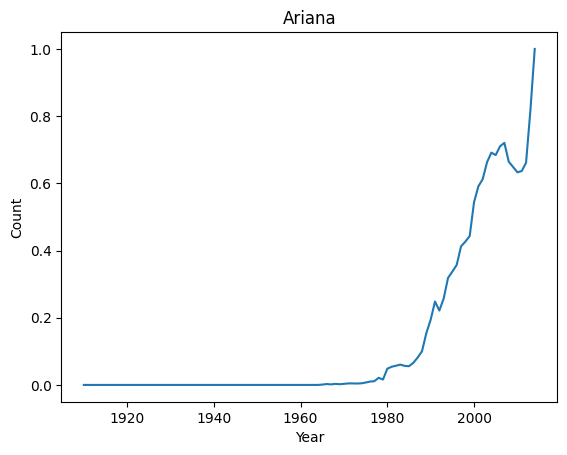

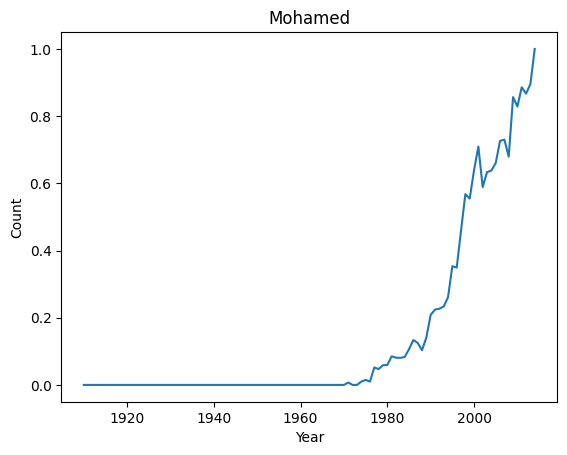

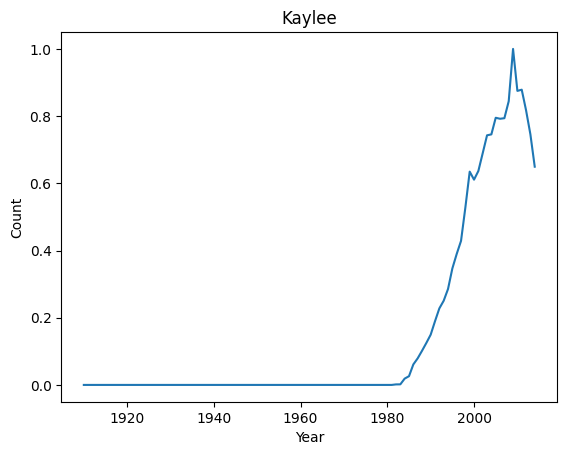

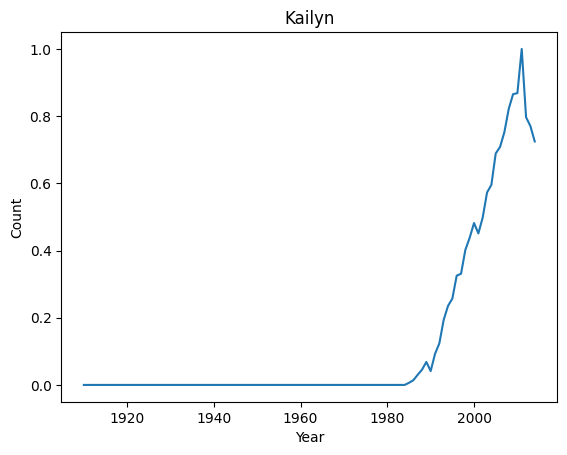

In [8]:
for normal in ordered_index[-4:]:
    basic_plot(normal)

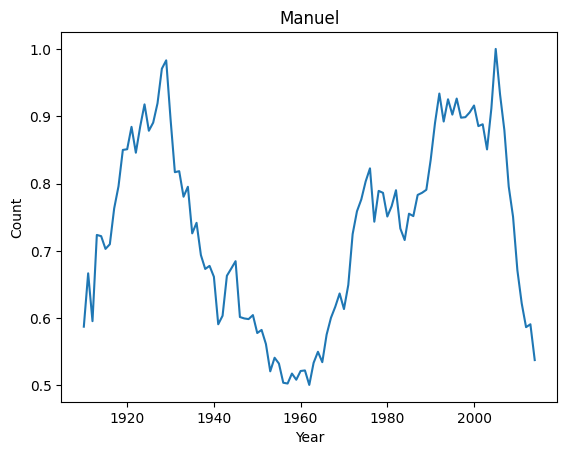

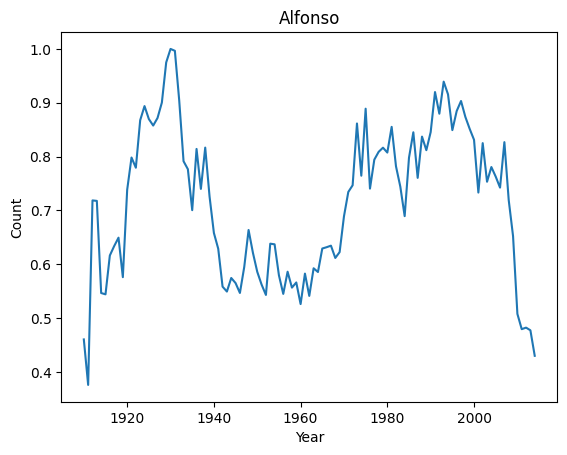

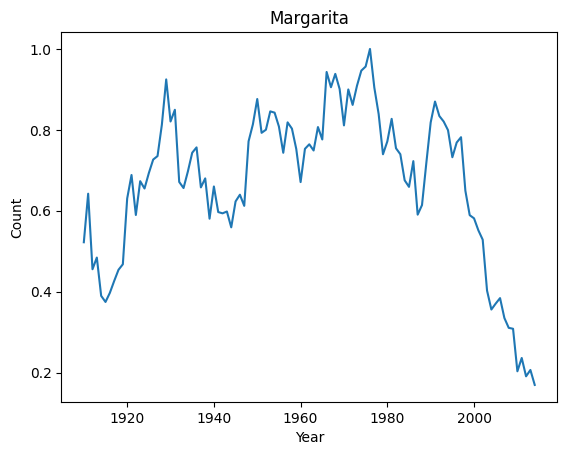

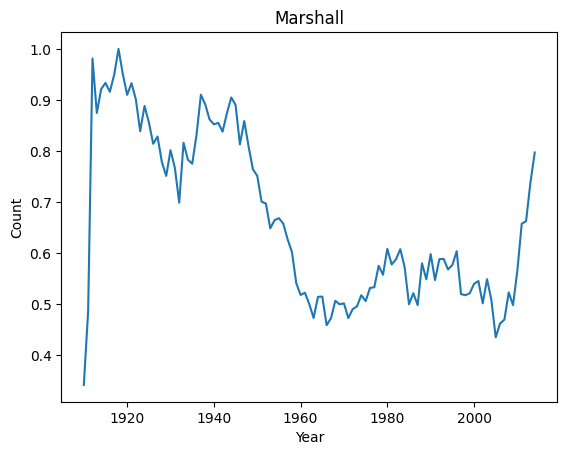

In [9]:
for weird in ordered_index[:4]:
    basic_plot(weird)

It seems that anomalies are either very localised peak or very recent trending names. Notice how Olive is a tricky one because it is both a localised peak and a recent trend

## Active Anomaly Detection 

First, we need a function helping us to make a decision.

### Comment dummy decision function and uncomment interactive one

In [10]:
# Comment
def help_decision(metadata, data, session):
    """Dummy, says YES to everything"""
    return Label.ANOMALY

### UNCOMMENT
# def help_decision(metadata, data, session):
#     """Plots data and asks expert interactively"""
#     basic_plot(metadata)
#     return prompt_decision_callback(metadata, data, session)

Let's create a model and run a session

Let's run PineForest and say YES every time we see a recent growth

In [11]:
model = PineForest(
    # Number of trees to use for predictions
    n_trees=256,
    # Number of new tree to grow for each decision
    n_spare_trees=768,
    # Fix random seed for reproducibility
    random_seed=0,
)
session = Session(
    data=final,
    metadata=final.index,
    model=model,
    decision_callback=help_decision,
    on_decision_callbacks=[
        TerminateAfter(10),
    ],
)
session.run()

Wow ! Good almost 100% of the behavior we were looking for

Now we can run it again and say YES every time we see a sharp peak

In [12]:
model = PineForest(
    # Number of trees to use for predictions
    n_trees=256,
    # Number of new tree to grow for each decision
    n_spare_trees=768,
    # Fix random seed for reproducibility
    random_seed=0,
)
session = Session(
    data=final,
    metadata=final.index,
    model=model,
    decision_callback=help_decision,
    on_decision_callbacks=[
        TerminateAfter(20),
    ],
)
session.run()

Again, very quickly PineForest learns the profile interesting for the user and outputs it